<a href="https://colab.research.google.com/github/jainsimoni/Telecom-Churn-Prediction/blob/main/Telecom_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cleaned Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)
eda_df = df.drop(columns=['customerID','TotalCharges', 'MonthlyCharges']).copy()

def count_blanks(df):
    blank_counts = {}
    for col in df.columns:
        blank_counts[col] = sum(df[col].apply(lambda x: str(x).strip() == ''))
    return blank_counts

blanks = count_blanks(df)

for col, count in blanks.items():
    if count > 0:
        print(f"Column '{col}' has {count} blank entries")


df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)

df['TotalCharges'] = df['TotalCharges'].astype(float)

df = df.dropna(subset=['TotalCharges'])

df = df.drop('customerID', axis=1)

df.reset_index(drop=True, inplace=True)

# Binary encoding
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:

    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Female': 1, 'Male': 0})

print("Columns before get_dummies:")
print(df.columns)

df = pd.get_dummies(df, columns=[
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod'
], drop_first=False)


scaler = StandardScaler()

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

df[num_cols] = scaler.fit_transform(df[num_cols])

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




Column 'TotalCharges' has 11 blank entries
Columns before get_dummies:
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


Plotting % of customers Vs each categorial factor

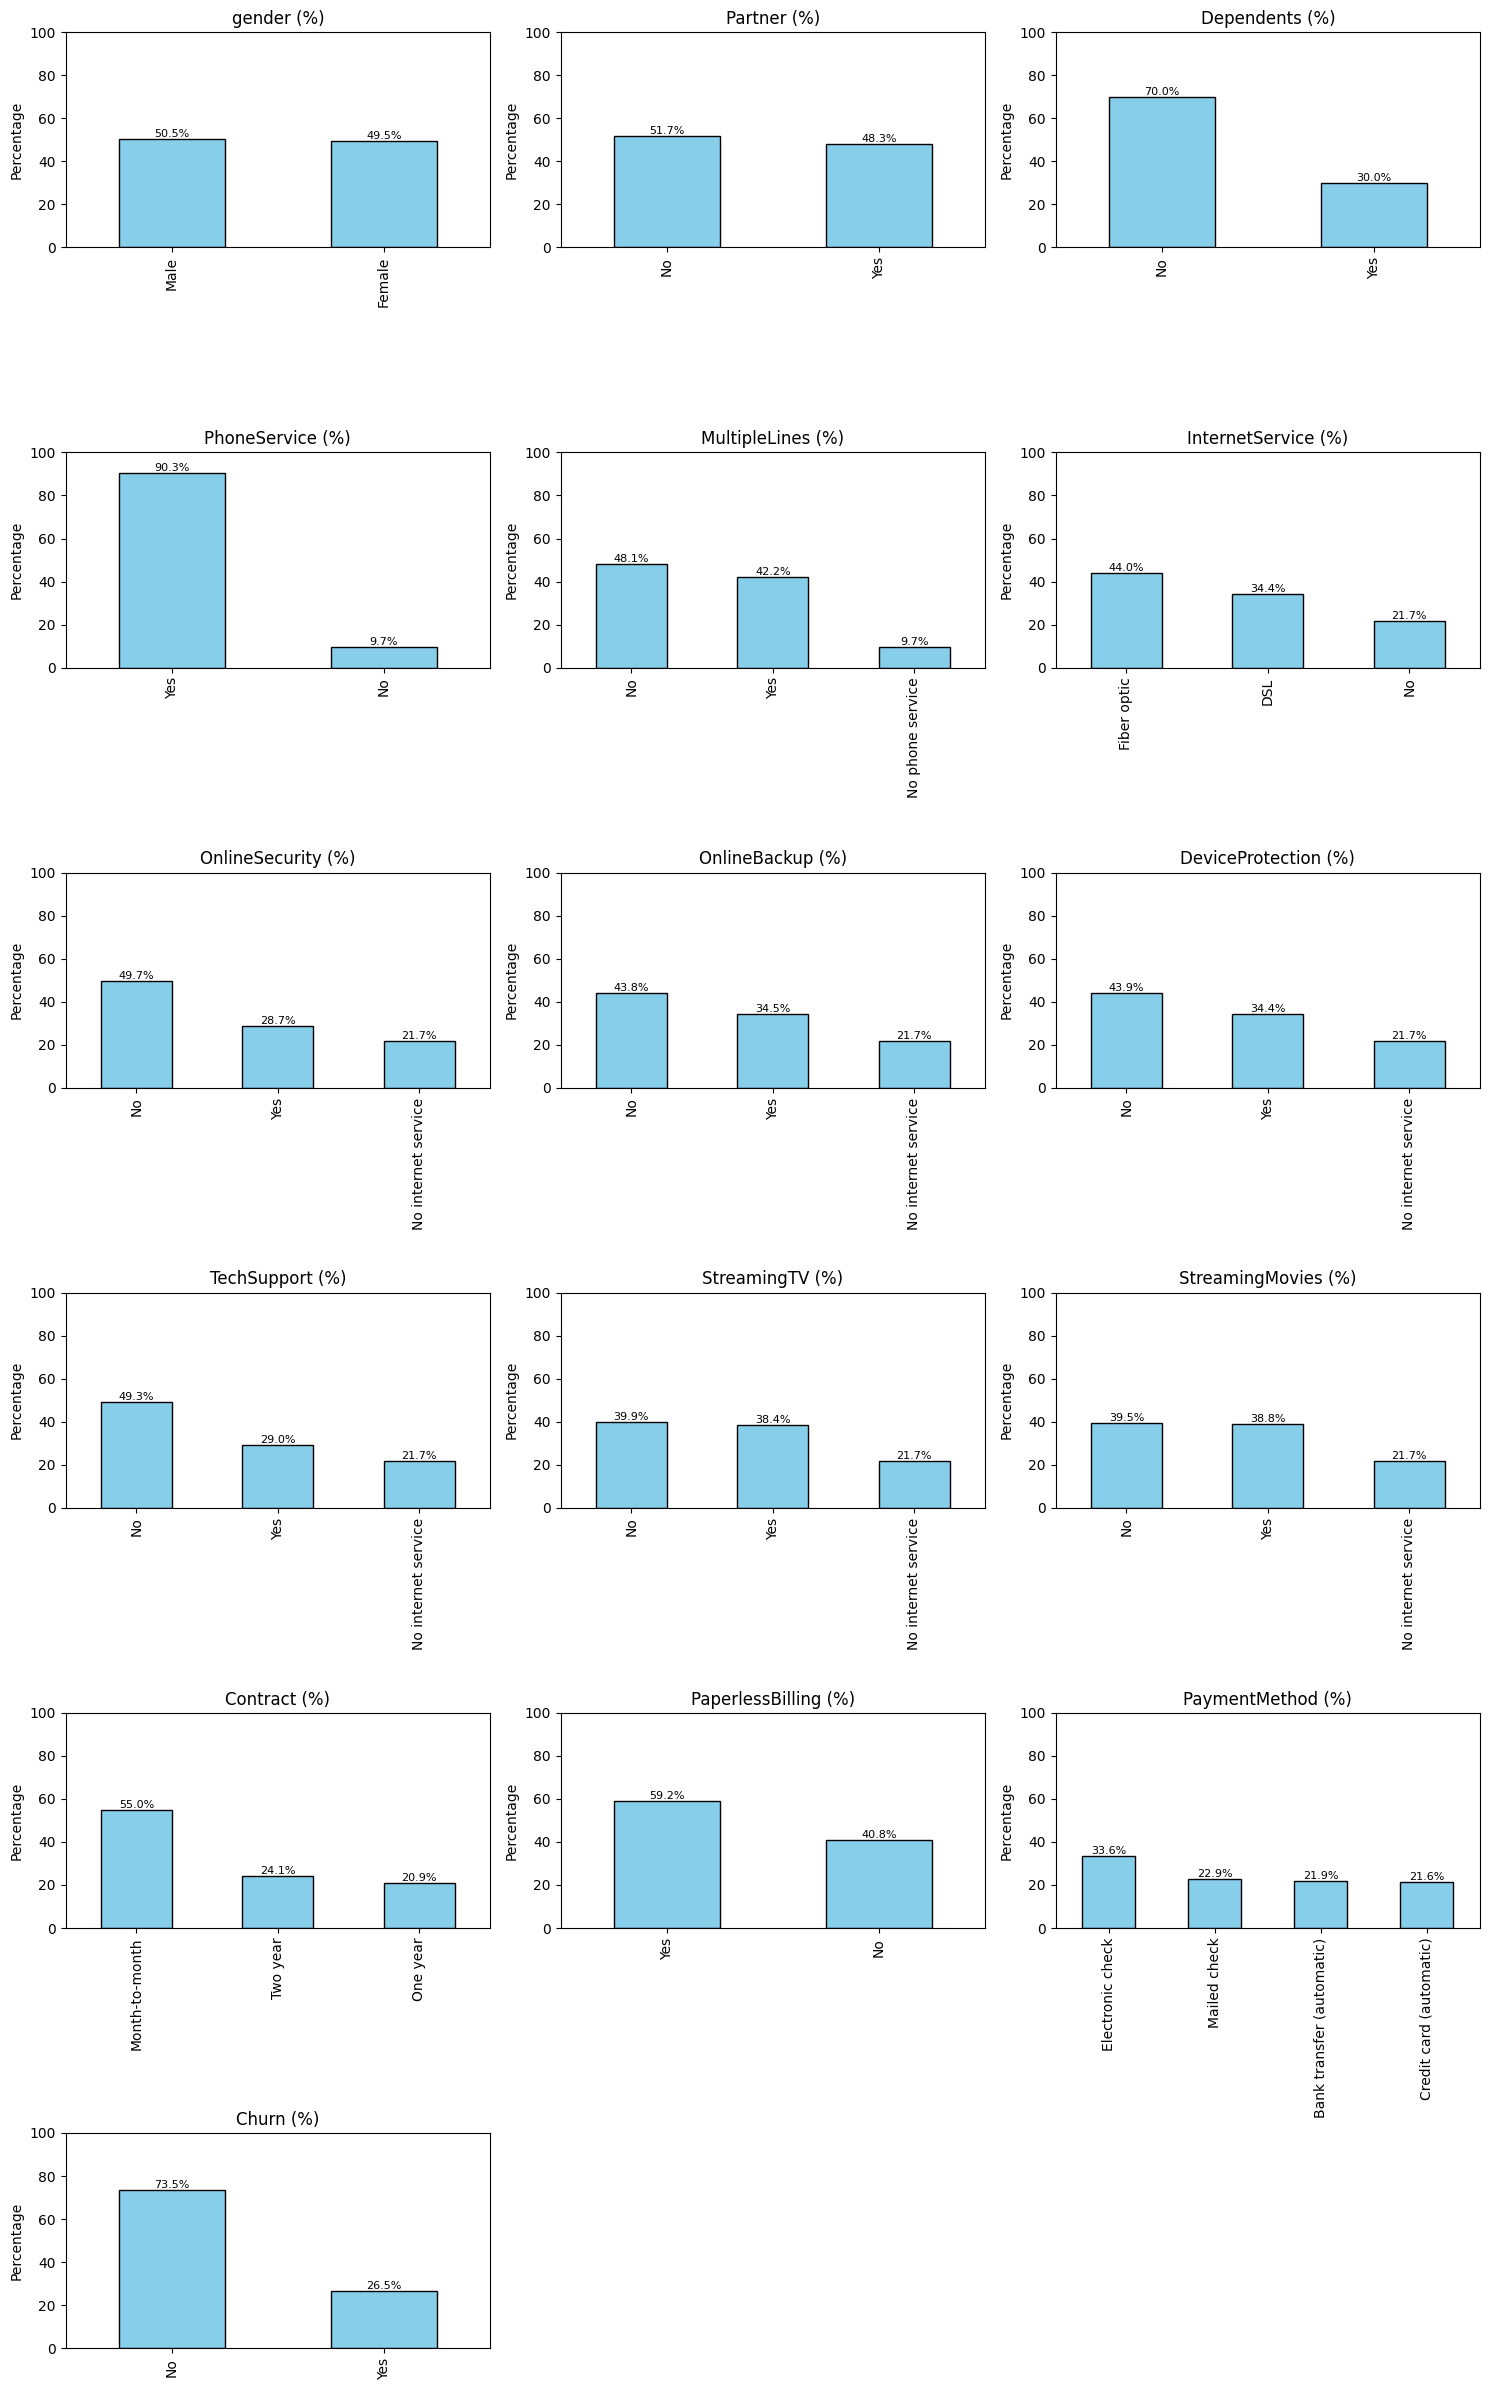

In [ ]:
import matplotlib.pyplot as plt

categorical_cols = eda_df.select_dtypes(include='object').columns.tolist()

n_cols = 3
n_rows = -(-len(categorical_cols) // n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    value_counts = eda_df[col].value_counts(normalize=True) * 100
    ax = axes[i]
    value_counts.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f"{col} (%)")
    ax.set_ylabel("Percentage")
    ax.set_xlabel("")
    ax.set_ylim(0, 100)
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=8)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



Logistic Regression -- Accuracy = 80%

In [ ]:
#logistic regression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


mean_error = np.mean(y_test != y_pred)
print(f"Mean Misclassification Error: {mean_error:.4f}")
print(f"Error Percentage: {mean_error * 100:.2f}%")

Confusion Matrix:
[[917 116]
 [159 215]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407

Mean Misclassification Error: 0.1955
Error Percentage: 19.55%


Feature Coefficient Calculation for determining dependence of each factor on churn

In [ ]:

feature_names = X.columns

coefficients = lr.coef_[0]

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("Top features affecting churn prediction:\n")
for i, row in coef_df.iterrows():
    sign = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"- {row['Feature']} ({row['Coefficient']:.4f}): This feature {sign} the chance of customer churn.")

coef_df[['Feature', 'Coefficient']].style.background_gradient(cmap='bwr', axis=0)


Top features affecting churn prediction:

- tenure (-1.3536): This feature decreases the chance of customer churn.
- Contract_Two year (-0.8189): This feature decreases the chance of customer churn.
- InternetService_DSL (-0.6624): This feature decreases the chance of customer churn.
- TotalCharges (0.6426): This feature increases the chance of customer churn.
- Contract_Month-to-month (0.5709): This feature increases the chance of customer churn.
- InternetService_Fiber optic (0.5502): This feature increases the chance of customer churn.
- MonthlyCharges (-0.5493): This feature decreases the chance of customer churn.
- DeviceProtection_No internet service (-0.3293): This feature decreases the chance of customer churn.
- StreamingTV_No internet service (-0.3293): This feature decreases the chance of customer churn.
- TechSupport_No internet service (-0.3293): This feature decreases the chance of customer churn.
- OnlineSecurity_No internet service (-0.3293): This feature decreases the 

,Feature,Coefficient
4,tenure,-1.353603
35,Contract_Two year,-0.818894
12,InternetService_DSL,-0.662367
8,TotalCharges,0.642573
33,Contract_Month-to-month,0.570920
13,InternetService_Fiber optic,0.550180
7,MonthlyCharges,-0.549332
22,DeviceProtection_No internet service,-0.329267
28,StreamingTV_No internet service,-0.329267
25,TechSupport_No internet service,-0.329267


Feature Coefficient Plot


Red bars (positive) ->These features increase the chance of churn
     
Green bars (negative) -> These features decrease the chance of churn

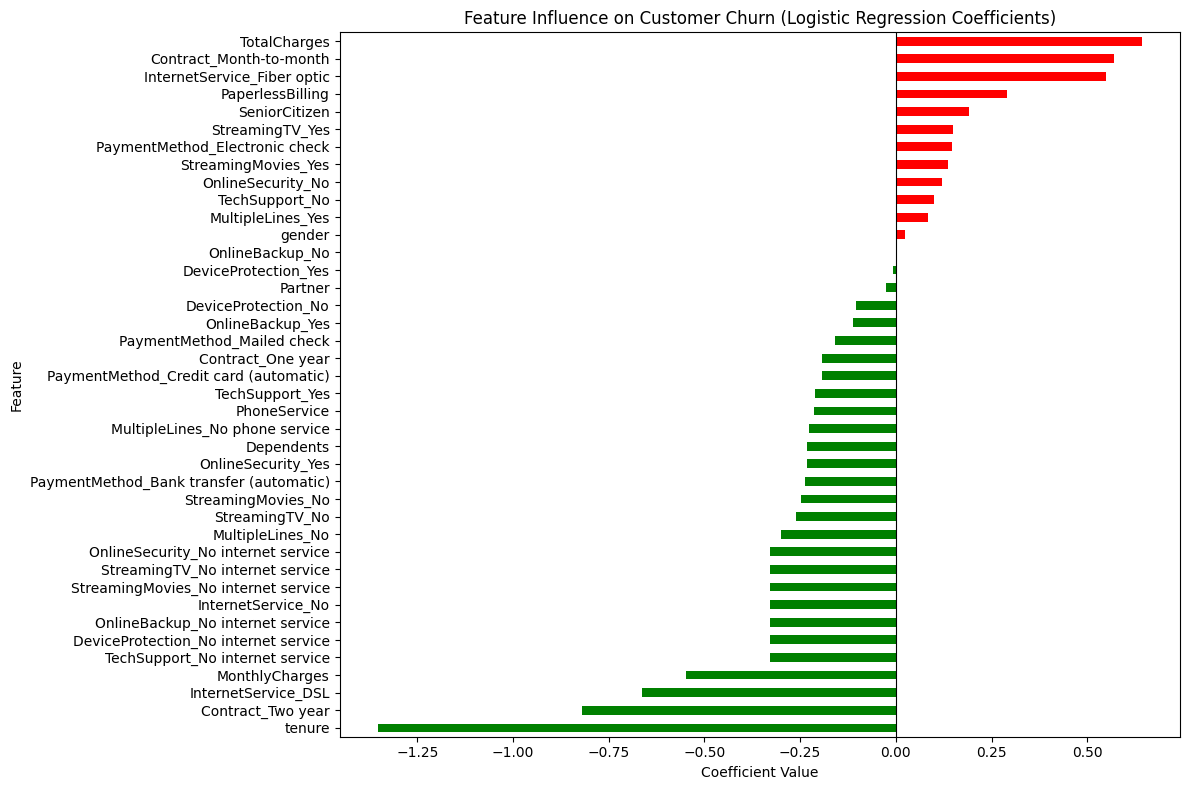

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

coefficients = pd.Series(lr.coef_[0], index=X.columns)

coefficients = coefficients.sort_values()

plt.figure(figsize=(12, 8))
coefficients.plot(kind='barh', color=coefficients.apply(lambda x: 'red' if x > 0 else 'green'))
plt.title('Feature Influence on Customer Churn (Logistic Regression Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


In [ ]:
df


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,-1.280248,0,1,-1.161694,-0.994194,0,...,True,False,False,True,False,False,False,False,True,False
1,0,0,0,0,0.064303,1,0,-0.260878,-0.173740,0,...,True,False,False,False,True,False,False,False,False,True
2,0,0,0,0,-1.239504,1,1,-0.363923,-0.959649,1,...,True,False,False,True,False,False,False,False,False,True
3,0,0,0,0,0.512486,0,0,-0.747850,-0.195248,0,...,True,False,False,False,True,False,True,False,False,False
4,1,0,0,0,-1.239504,1,1,0.196178,-0.940457,1,...,True,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0,0,1,1,-0.343137,1,1,0.664868,-0.129180,0,...,False,False,True,False,True,False,False,False,False,True
7028,1,0,1,1,1.612573,1,1,1.276493,2.241056,0,...,False,False,True,False,True,False,False,True,False,False
7029,1,0,1,1,-0.872808,0,1,-1.170004,-0.854514,0,...,True,False,False,True,False,False,False,False,True,False
7030,0,1,1,0,-1.158016,1,1,0.319168,-0.872095,1,...,True,False,False,True,False,False,False,False,False,True


KNN -- accuracy = 77% , not as good very way plot for k values


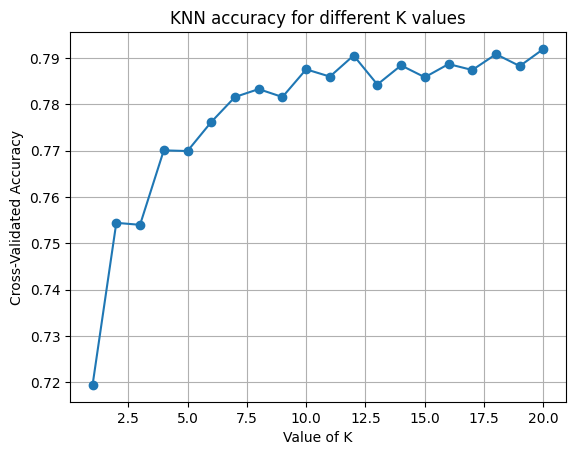

In [ ]:
#KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

scores = []
k_range = range(1, 21)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5).mean()
    scores.append(score)

plt.plot(k_range, scores, marker='o')
plt.xlabel('Value of K')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN accuracy for different K values')
plt.grid()
plt.show()


In [ ]:
best_k = 4
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)

y_pred = knn_final.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[924 109]
 [223 151]]
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1033
           1       0.58      0.40      0.48       374

    accuracy                           0.76      1407
   macro avg       0.69      0.65      0.66      1407
weighted avg       0.75      0.76      0.75      1407



Decision Tree - accuracy = 70% and feature importance plot

Confusion Matrix:
[[836 197]
 [184 190]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1033
           1       0.49      0.51      0.50       374

    accuracy                           0.73      1407
   macro avg       0.66      0.66      0.66      1407
weighted avg       0.73      0.73      0.73      1407

Accuracy: 0.7292110874200426


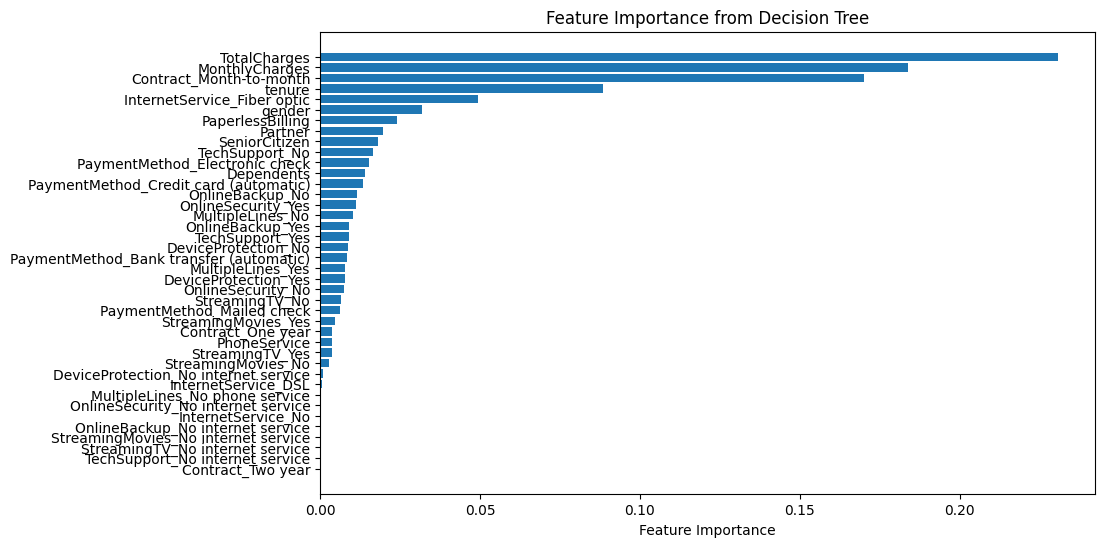

In [ ]:
#Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

dtree = DecisionTreeClassifier(random_state=42)

dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))

importances = dtree.feature_importances_

feature_names = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Decision Tree')
plt.show()


Random Forest using 100 decision trees -- accuracy = 79%

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))


Confusion Matrix:
[[921 112]
 [189 185]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.77      0.79      0.78      1407

Accuracy: 0.7860696517412935


Feature Importance using Random forest


<ipython-input-15-f9070530a4b8>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')


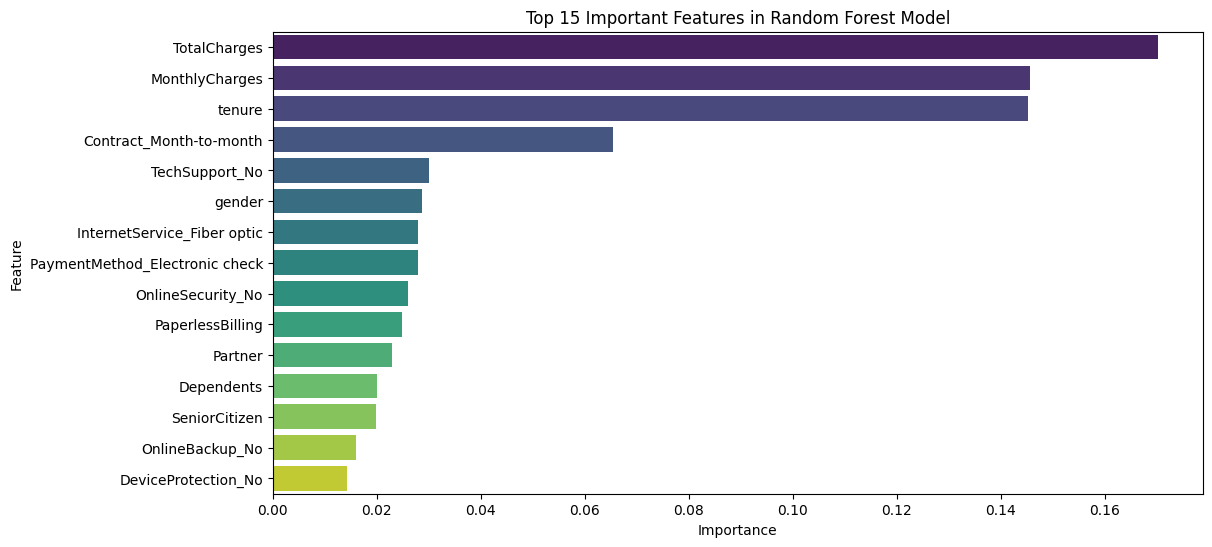

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Important Features in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


To find best parameters using cross validation (5folds)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy')

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

print("Test set accuracy after tuning:", accuracy_score(y_test, y_pred_best))


Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.8018
Test set accuracy after tuning: 0.7995735607675906


Ensemble - accuracy = 79% , divided dataset into 3 parts and trained on knn, logistic and random forest


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import mode

url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float)
df.dropna(subset=['TotalCharges'], inplace=True)
df.drop('customerID', axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Female': 1, 'Male': 0})

df = pd.get_dummies(df, columns=[
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod'
], drop_first=True)

scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols] = scaler.fit_transform(df[num_cols])

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X1, X_temp, y1, y_temp = train_test_split(X_train, y_train, test_size=2/3, stratify=y_train, random_state=1)
X2, X3, y2, y3 = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=1)

model1 = LogisticRegression(max_iter=1000)
model1.fit(X1, y1)
pred1 = model1.predict(X_test)

model2 = KNeighborsClassifier(n_neighbors=5)
model2.fit(X2, y2)
pred2 = model2.predict(X_test)

model3 = RandomForestClassifier(n_estimators=100, random_state=42)
model3.fit(X3, y3)
pred3 = model3.predict(X_test)

from scipy.stats import mode
from sklearn.metrics import accuracy_score, classification_report

predictions = np.array([pred1, pred2, pred3])
final_prediction = mode(predictions, axis=0).mode.squeeze()

print("Ensemble Majority Voting Accuracy:", accuracy_score(y_test, final_prediction))
print(classification_report(y_test, final_prediction))





Ensemble Majority Voting Accuracy: 0.7889125799573561
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.62      0.53      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.78      1407



Boosting (KNN → Random Forest → Logistic) accuracy = 92%

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
pred_knn_train = knn.predict(X_train)


errors_knn = (pred_knn_train != y_train)
X_rf = X_train[errors_knn]
y_rf = y_train[errors_knn]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
if len(X_rf) > 0:
    rf.fit(X_rf, y_rf)
    pred_rf_train = rf.predict(X_rf)

    errors_rf = (pred_rf_train != y_rf)
    X_log = X_rf[errors_rf]
    y_log = y_rf[errors_rf]

    if len(X_log) > 0:
        log = LogisticRegression(max_iter=1000)
        log.fit(X_log, y_log)
    else:
        log = None
else:
    rf = None
    log = None


pred_final = knn.predict(X_test)

if rf is not None:
    errors_test_knn = (pred_final != y_test)
    if np.any(errors_test_knn):
        pred_rf_test = rf.predict(X_test[errors_test_knn])
        pred_final[errors_test_knn] = pred_rf_test


        if log is not None:
            errors_test_rf = (pred_final != y_test)
            if np.any(errors_test_rf):
                pred_lr_test = log.predict(X_test[errors_test_rf])
                pred_final[errors_test_rf] = pred_lr_test

print("Boosting (KNN → RF → LR) Accuracy:", accuracy_score(y_test, pred_final))
print(classification_report(y_test, pred_final))

from sklearn.metrics import confusion_matrix
import pandas as pd

# Reset index to align with y_test
y_test_reset = y_test.reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)

# Step 1: Create DataFrame with predictions vs actuals
results_df = pd.DataFrame({
    'Actual': y_test_reset,
    'Predicted': pred_final
})

# Step 2: Filter False Negatives (Actual=1, Predicted=0)
false_negatives = results_df[(results_df['Actual'] == 1) & (results_df['Predicted'] == 0)]

# Step 3: Get their feature values
false_negative_features = X_test_reset.loc[false_negatives.index]

# Optional: Display count
print(f"\nTotal False Negatives: {len(false_negative_features)}")

#predicted 0(no churn) but were actually 1(churn)

Boosting (KNN → RF → LR) Accuracy: 0.9225302061122956
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1033
           1       0.84      0.88      0.86       374

    accuracy                           0.92      1407
   macro avg       0.90      0.91      0.90      1407
weighted avg       0.92      0.92      0.92      1407


Total False Negatives: 46


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Reset index of test data and predictions to align properly
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Step 1: Store actual vs predicted
results_df = pd.DataFrame({
    'Actual': y_test_reset,
    'Predicted': pred_final
})

# Step 2: Identify False Negatives (Actual = 1, Predicted = 0)
false_negatives = results_df[(results_df['Actual'] == 1) & (results_df['Predicted'] == 0)]

# Step 3: Extract corresponding test set feature values
false_negative_features = X_test_reset.loc[false_negatives.index].copy()

# Step 4: Add actual churn info back
false_negative_features['Actual'] = y_test_reset.loc[false_negatives.index].values

# Optional: Save for analysis
false_negative_features.to_csv("false_negative_customers.csv", index=False)



In [ ]:
import pandas as pd

# Load false negatives Excel file
false_negatives = pd.read_csv('false_negative_customers.csv')

print(false_negatives.describe())


          gender  SeniorCitizen    Partner  Dependents     tenure  \
count  46.000000      46.000000  46.000000   46.000000  46.000000   
mean    0.565217       0.239130   0.282609    0.239130  -0.348451   
std     0.501206       0.431266   0.455243    0.431266   0.727868   
min     0.000000       0.000000   0.000000    0.000000  -1.280248   
25%     0.000000       0.000000   0.000000    0.000000  -0.791321   
50%     1.000000       0.000000   0.000000    0.000000  -0.546857   
75%     1.000000       0.000000   1.000000    0.000000  -0.027371   
max     1.000000       1.000000   1.000000    1.000000   1.531085   

       PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  Actual  
count     46.000000         46.000000       46.000000     46.000000    46.0  
mean       0.913043          0.782609        0.536784     -0.083981     1.0  
std        0.284885          0.417029        0.652401      0.802625     0.0  
min        0.000000          0.000000       -1.342854     -0.99123

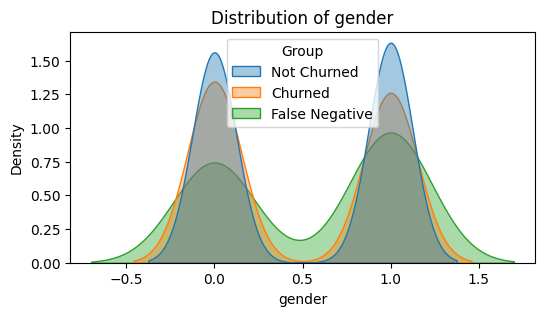

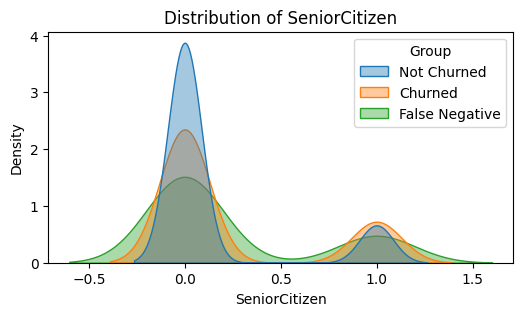

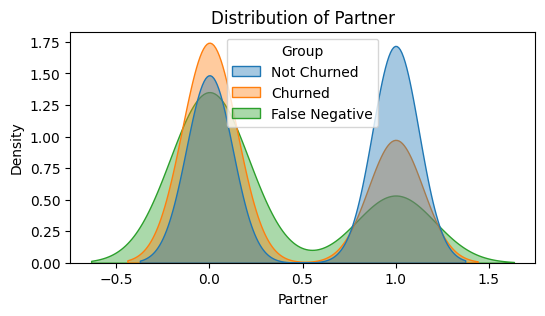

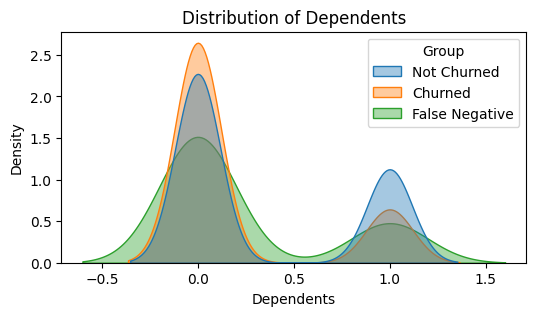

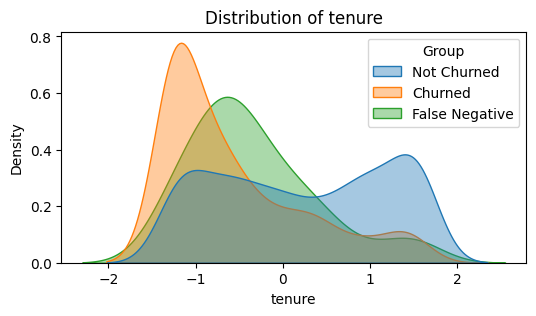

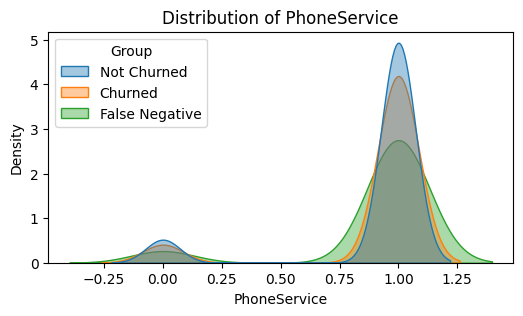

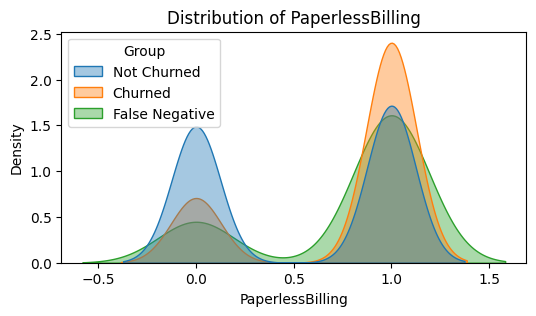

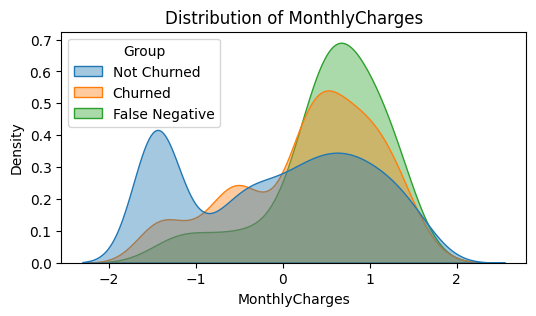

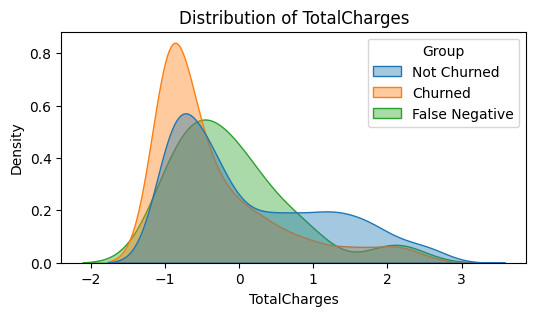

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your false negative customers
false_neg = pd.read_csv('false_negative_customers.csv')
false_neg['Group'] = 'False Negative'

# Also include your full test data
X_test_reset['Actual'] = y_test_reset.values
X_test_reset['Group'] = X_test_reset['Actual'].apply(lambda x: 'Churned' if x == 1 else 'Not Churned')

# Combine both for comparison
combined = pd.concat([X_test_reset, false_neg], ignore_index=True)

# Only take numeric features
numeric_cols = combined.select_dtypes(include='number').columns.drop(['Actual'])

# Plot comparison
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(data=combined, x=col, hue='Group', fill=True, common_norm=False, alpha=0.4)
    plt.title(f'Distribution of {col}')
    plt.show()


In [ ]:
# Step 1: Convert "TRUE"/"FALSE" to bool then int
bool_cols = ['MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No',
             'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes',
             'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes',
             'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes',
             'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check',
             'PaymentMethod_Mailed check']

for col in bool_cols:
    # Map the 'TRUE'/'FALSE' strings to boolean. Any other values (like NaN) will remain as they are.
    false_negative_features[col] = false_negative_features[col].map({'TRUE': True, 'FALSE': False})

# Fill any remaining NaN values in these columns with 0 before converting to int
false_negative_features[bool_cols] = false_negative_features[bool_cols].fillna(0).astype(int)

# Step 2: Ensure numeric columns are numeric type
numeric_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling',
                'MonthlyCharges', 'TotalCharges', 'Actual']
false_negative_features[numeric_cols] = false_negative_features[numeric_cols].apply(pd.to_numeric)

# Step 3: Prepare feature matrix for clustering (drop Actual)
X_fn = false_negative_features.drop(columns=['Actual'])

# Step 4: Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_fn_scaled = scaler.fit_transform(X_fn)

<ipython-input-32-0fc46d140160>:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  false_negative_features[bool_cols] = false_negative_features[bool_cols].fillna(0).astype(int)


In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Choose number of clusters (try 2 or 3 to start)
k = 4

kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_fn_scaled)

# Add cluster labels back to the dataframe for analysis
false_negative_features['Cluster'] = clusters

# See cluster sizes
print(false_negative_features['Cluster'].value_counts())



Cluster
0    20
1    17
2     5
3     4
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Add the cluster assignments to your false_negative_features DataFrame
false_negative_features['Cluster'] = clusters  # clusters from your clustering result

# For each cluster, create a binary label: 1 if in that cluster, 0 otherwise
feature_cols = false_negative_features.columns.drop(['Actual', 'Cluster'])

for cluster_id in sorted(false_negative_features['Cluster'].unique()):
    print(f"\nFeature importance for Cluster {cluster_id}:")

    # Create binary target for this cluster vs all others
    y_cluster = (false_negative_features['Cluster'] == cluster_id).astype(int)

    # Extract feature matrix for clustering
    X_cluster = false_negative_features[feature_cols]

    # Train a RandomForest to classify cluster membership
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_cluster, y_cluster)

    # Get feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print(feature_importance_df.head(10))



Feature importance for Cluster 0:
                          Feature  Importance
0                          gender    0.384847
8                    TotalCharges    0.142727
7                  MonthlyCharges    0.136432
4                          tenure    0.111040
3                      Dependents    0.072287
1                   SeniorCitizen    0.045912
2                         Partner    0.042945
6                PaperlessBilling    0.032253
5                    PhoneService    0.031556
9  MultipleLines_No phone service    0.000000

Feature importance for Cluster 1:
                          Feature  Importance
0                          gender    0.359652
8                    TotalCharges    0.148466
7                  MonthlyCharges    0.138241
4                          tenure    0.134817
6                PaperlessBilling    0.073363
3                      Dependents    0.042605
2                         Partner    0.040256
5                    PhoneService    0.039204
1         

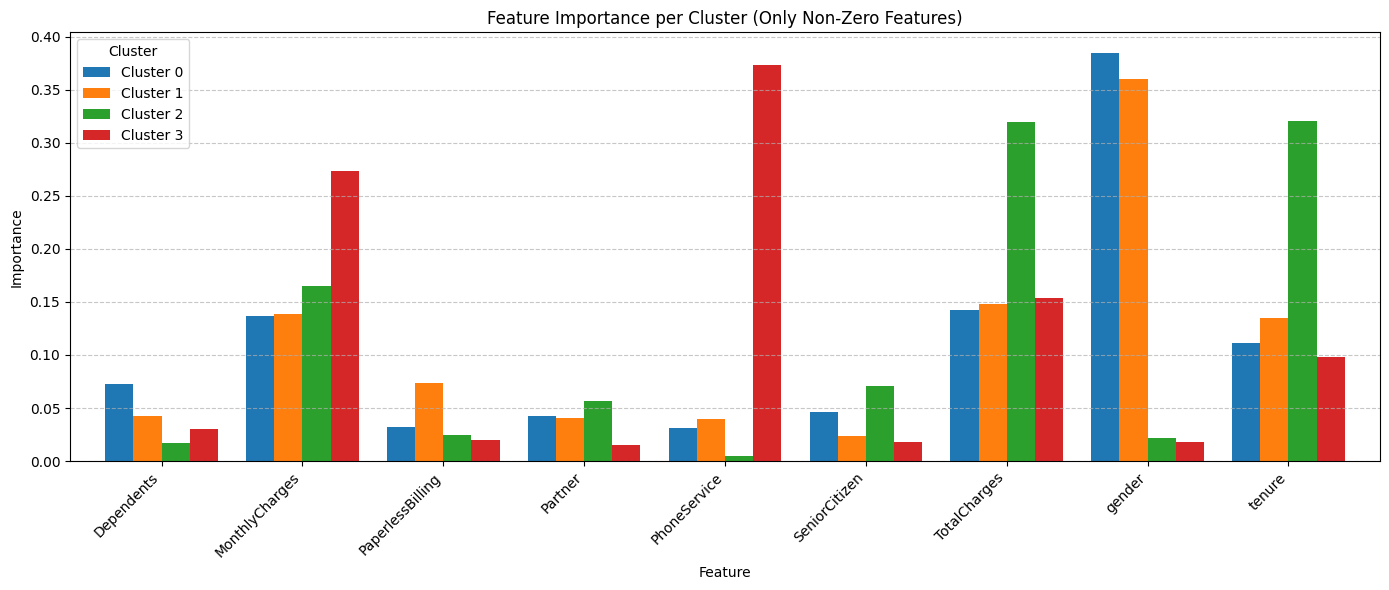

In [ ]:
import matplotlib.pyplot as plt

# Optional: collect all feature importances for plotting
cluster_importance_dfs = []

for cluster_id in sorted(false_negative_features['Cluster'].unique()):
    y_cluster = (false_negative_features['Cluster'] == cluster_id).astype(int)
    X_cluster = false_negative_features[feature_cols]

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_cluster, y_cluster)

    importances = rf.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances,
        'Cluster': f'Cluster {cluster_id}'
    })
    cluster_importance_dfs.append(importance_df)


# Combine full data
all_importances_df = pd.concat(cluster_importance_dfs)

# Pivot table
pivot_df = all_importances_df.pivot(index='Feature', columns='Cluster', values='Importance').fillna(0)

# Drop features with total importance = 0 across all clusters
pivot_df = pivot_df[(pivot_df.sum(axis=1) > 0)]

# Plot
pivot_df.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.title("Feature Importance per Cluster (Only Non-Zero Features)")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Cluster 0 (Blue):
High dependence on gender and TotalCharges.

Suggests that gender bias or incorrect handling of charge data could be confusing the model here.

Cluster 1 (Orange):
Also influenced by gender, TotalCharges, and MonthlyCharges.

Similar to Cluster 0 but with more weight on billing, possibly a group that is misclassified due to billing behavior.

Cluster 2 (Green):
Dominated by tenure, TotalCharges.

Indicates new or long-term users (tenure) are being misclassified. The model might not generalize well across customer lifecycle stages.

Cluster 3 (Red):
Highly dependent on PhoneService and MonthlyCharges.

This is the most unique cluster: the model fails for elderly users with specific service setups, possibly due to underrepresentation or unique usage patterns.



In [ ]:
# Step 1: Filter False Positives (Actual=0, Predicted=1)
false_positives = results_df[(results_df['Actual'] == 0) & (results_df['Predicted'] == 1)]

# Step 2: Get their feature values
false_positive_features = X_test_reset.loc[false_positives.index]

# Optional: Display count
print(f"\nTotal False Positives: {len(false_positive_features)}")

# predicted 1 (churn) but were actually 0 (no churn)



Total False Positives: 63


In [ ]:
# Assuming X_test, y_test, and pred_final are defined as before

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Reset index of test data and predictions to align properly
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Step 1: Store actual vs predicted
results_df = pd.DataFrame({
    'Actual': y_test_reset,
    'Predicted': pred_final
})

# Step 2: Identify False Positives (Actual = 0, Predicted = 1)
false_positives = results_df[(results_df['Actual'] == 0) & (results_df['Predicted'] == 1)]

# Step 3: Extract corresponding test set feature values
false_positive_features = X_test_reset.loc[false_positives.index].copy()

# Step 4: Add actual churn info back
false_positive_features['Actual'] = y_test_reset.loc[false_positives.index].values

# Optional: Save for analysis
false_positive_features.to_csv("false_positive_customers.csv", index=False)


# --- Load false positives data if needed ---
# false_positive_features = pd.read_csv('false_positive_customers.csv')

# Step 1: Convert "TRUE"/"FALSE" to bool then int for relevant columns (same as false negatives)
bool_cols = ['MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No',
             'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes',
             'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes',
             'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes',
             'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check',
             'PaymentMethod_Mailed check']

for col in bool_cols:
    false_positive_features[col] = false_positive_features[col].map({'TRUE': True, 'FALSE': False})

false_positive_features[bool_cols] = false_positive_features[bool_cols].fillna(0).astype(int)

# Step 2: Ensure numeric columns are numeric type
numeric_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling',
                'MonthlyCharges', 'TotalCharges', 'Actual']
false_positive_features[numeric_cols] = false_positive_features[numeric_cols].apply(pd.to_numeric)

# Step 3: Prepare feature matrix for clustering (drop Actual)
X_fp = false_positive_features.drop(columns=['Actual'])

# Step 4: Scale features
scaler = StandardScaler()
X_fp_scaled = scaler.fit_transform(X_fp)

# Step 5: KMeans clustering (try k=4 as before)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_fp_scaled)

# Add cluster labels back to dataframe
false_positive_features['Cluster'] = clusters

# Check cluster sizes
print(false_positive_features['Cluster'].value_counts())

# Step 6: Feature importance per cluster using RandomForestClassifier
feature_cols = false_positive_features.columns.drop(['Actual', 'Cluster'])

for cluster_id in sorted(false_positive_features['Cluster'].unique()):
    print(f"\nFeature importance for Cluster {cluster_id}:")
    y_cluster = (false_positive_features['Cluster'] == cluster_id).astype(int)
    X_cluster = false_positive_features[feature_cols]

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_cluster, y_cluster)

    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print(feature_importance_df.head(10))





<ipython-input-53-282373777127>:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  false_positive_features[bool_cols] = false_positive_features[bool_cols].fillna(0).astype(int)


Cluster
0    25
1    20
2    10
3     8
Name: count, dtype: int64

Feature importance for Cluster 0:
                          Feature  Importance
4                          tenure    0.277075
8                    TotalCharges    0.227973
7                  MonthlyCharges    0.152296
2                         Partner    0.092878
1                   SeniorCitizen    0.085224
5                    PhoneService    0.081451
6                PaperlessBilling    0.039285
0                          gender    0.027903
3                      Dependents    0.015914
9  MultipleLines_No phone service    0.000000

Feature importance for Cluster 1:
                          Feature  Importance
8                    TotalCharges    0.245493
7                  MonthlyCharges    0.224950
4                          tenure    0.191809
2                         Partner    0.130522
1                   SeniorCitizen    0.076981
3                      Dependents    0.066228
5                    PhoneService   

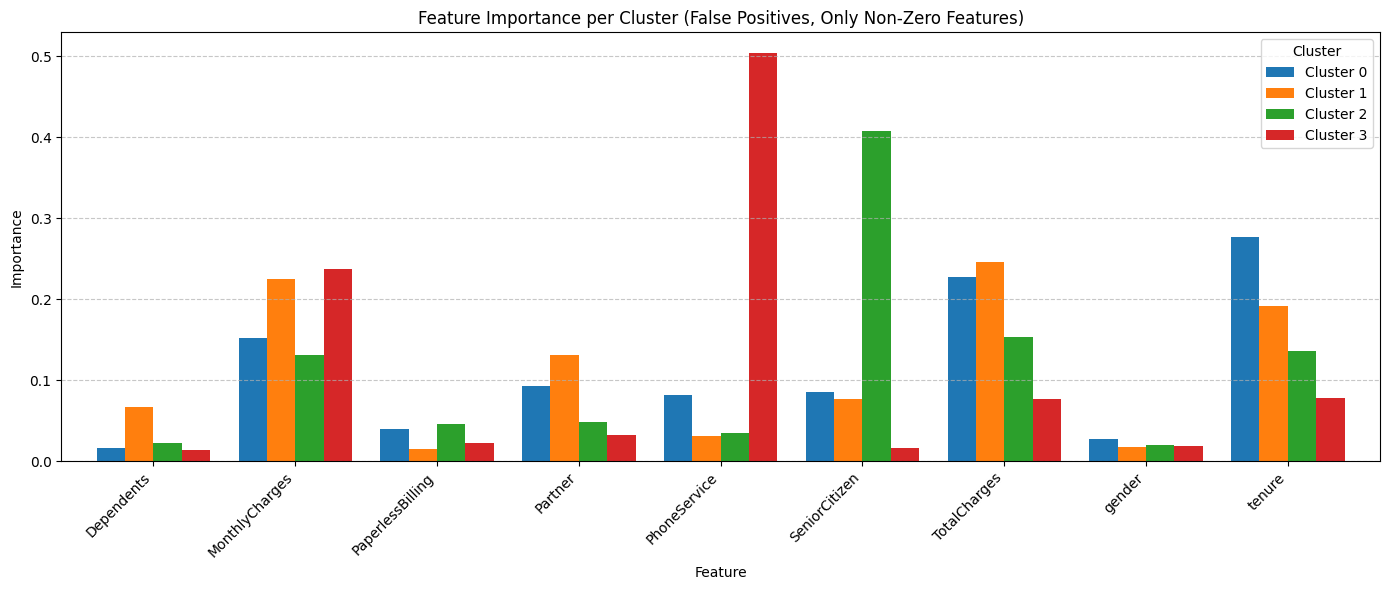

In [ ]:
# Optional: Plot combined feature importances for all clusters
cluster_importance_dfs = []

for cluster_id in sorted(false_positive_features['Cluster'].unique()):
    y_cluster = (false_positive_features['Cluster'] == cluster_id).astype(int)
    X_cluster = false_positive_features[feature_cols]

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_cluster, y_cluster)

    importances = rf.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances,
        'Cluster': f'Cluster {cluster_id}'
    })
    cluster_importance_dfs.append(importance_df)

all_importances_df = pd.concat(cluster_importance_dfs)
pivot_df = all_importances_df.pivot(index='Feature', columns='Cluster', values='Importance').fillna(0)
pivot_df = pivot_df[(pivot_df.sum(axis=1) > 0)]

pivot_df.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.title("Feature Importance per Cluster (False Positives, Only Non-Zero Features)")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Cluster 0 (Blue):
Most important feature: tenure,totalcharges indicating that the length of customer tenure is a key factor in false positives for this cluster.

Cluster 1 (Orange):
Most important feature: MonthlyCharges, totalcharges showing that monthly billing amounts are the primary driver of false positives here.

Cluster 2 (Green):
Most important feature: Senior citizen, highlighting that the total amount billed is the dominant factor for false positives in this cluster.

Cluster 3 (Red):
Most important feature: PhoneService, meaning that whether a customer is a senior citizen is the most critical factor for false positives in this cluster.